## Pytorch Implementation with MCE

**Design choice**: We choose epoch 100, with a batch size of 16 (Pytorch default), and learning rate be 0.01. Since there are only several hundreds data in the training dataset, 16 * 100 = 1600 number of samplings from the training set with replacement would be adequate enough while also maintaining manageable performance.

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [64]:
## function for plot learning curves

def plot_learning_curves(train_loss, val_loss, title="Learning Curves"):
    """
    Plot the learning curves for training and validation loss.

    Parameters:
    - train_loss: List of training loss values over epochs.
    - val_loss: List of validation loss values over epochs.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_best_decision_surface(model, x_test, y_test, title="Decision Surface", axis_limits = (-5,5,-5,5)):
    """
    Plot the decision surface of the best model using test data.

    Parameters:
    - model: Trained model to generate predictions.
    - x_test: Test dataset features (2D array).
    - y_test: Test dataset labels.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model, axis_limits = axis_limits)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

 Pytorch Implementation with MCE: 
hyperparameters: 
 epochs: 100 
 learning_rate: 0.01 
 batch size: 16


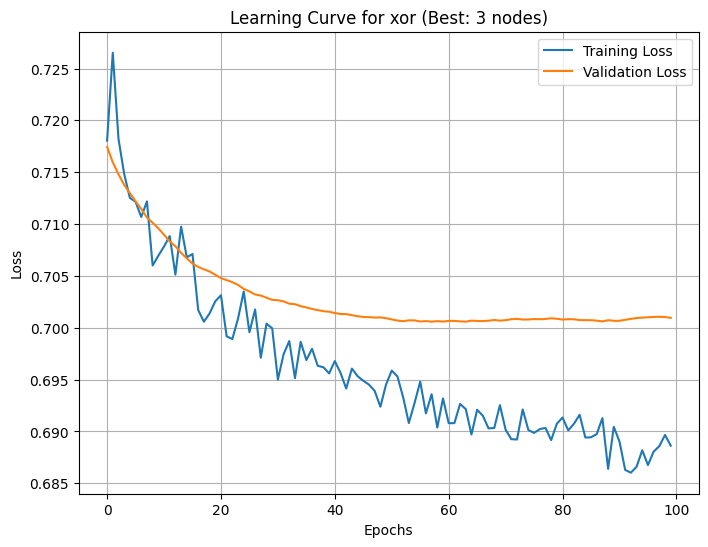

final text accuracy for xor: 0.635


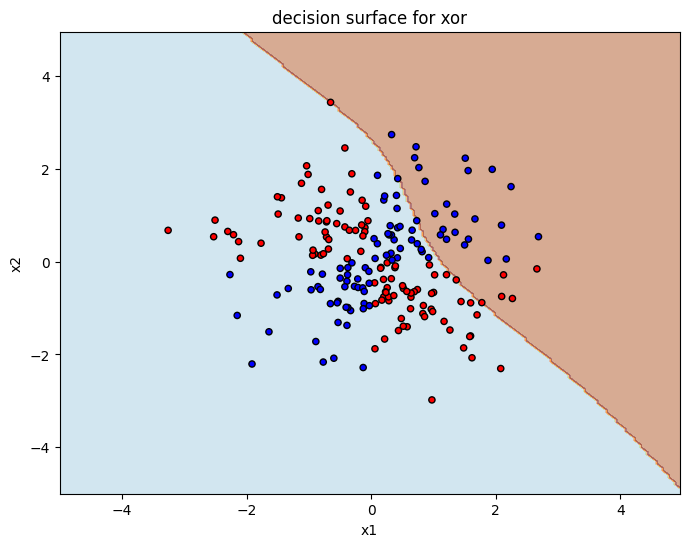

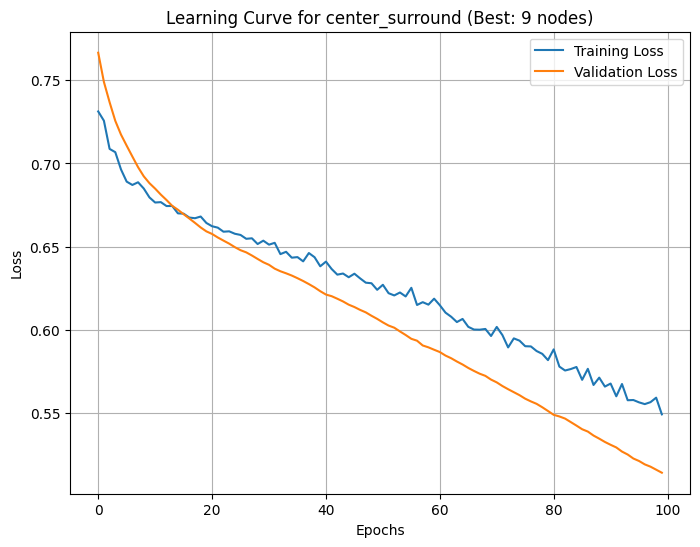

final text accuracy for center_surround: 0.65


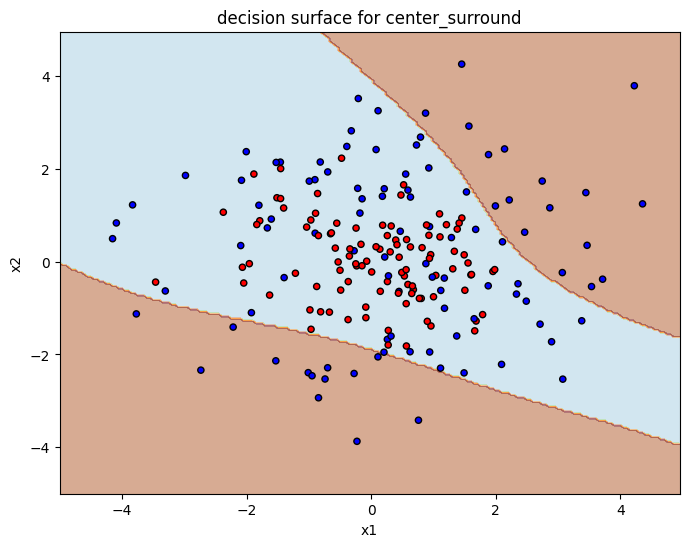

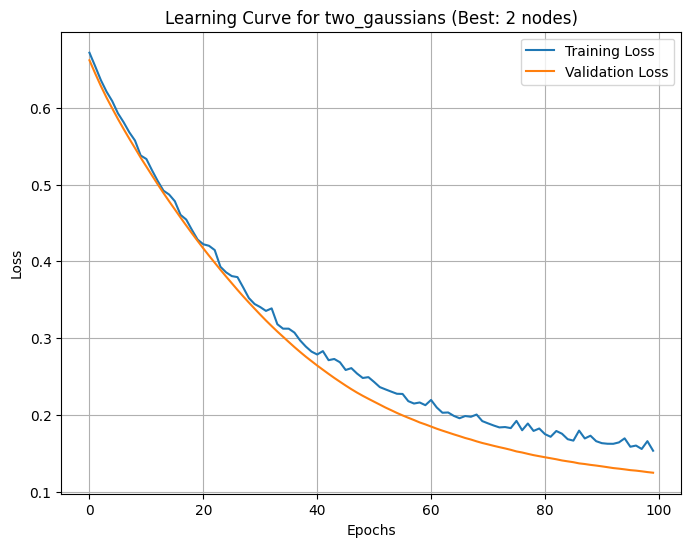

final text accuracy for two_gaussians: 0.915


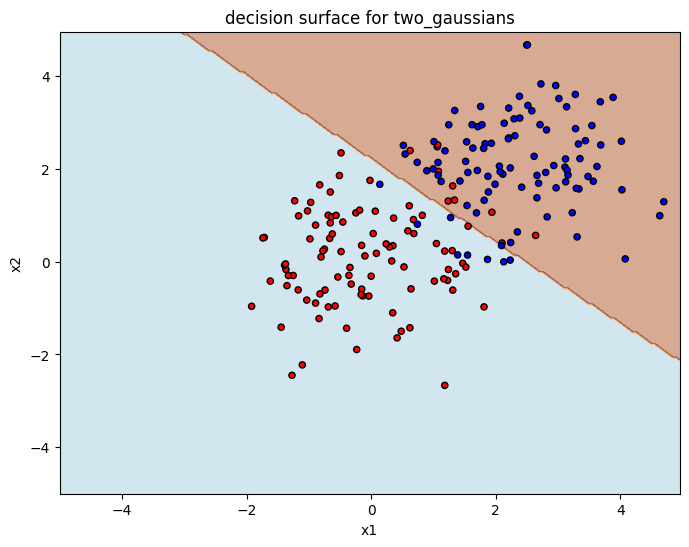

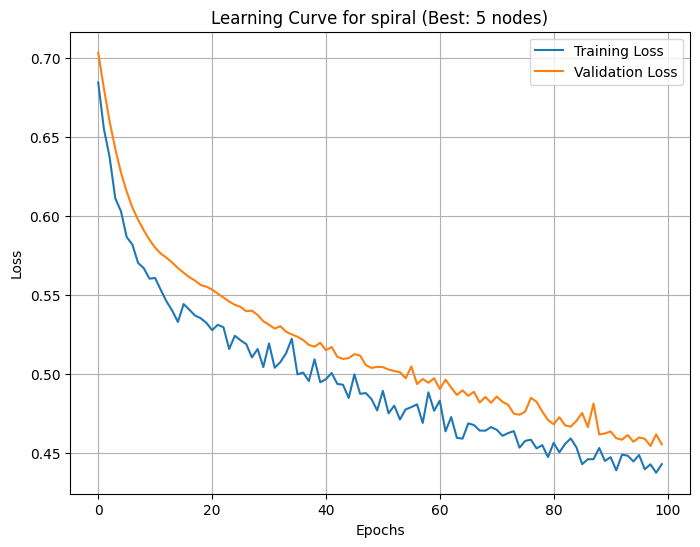

final text accuracy for spiral: 0.82


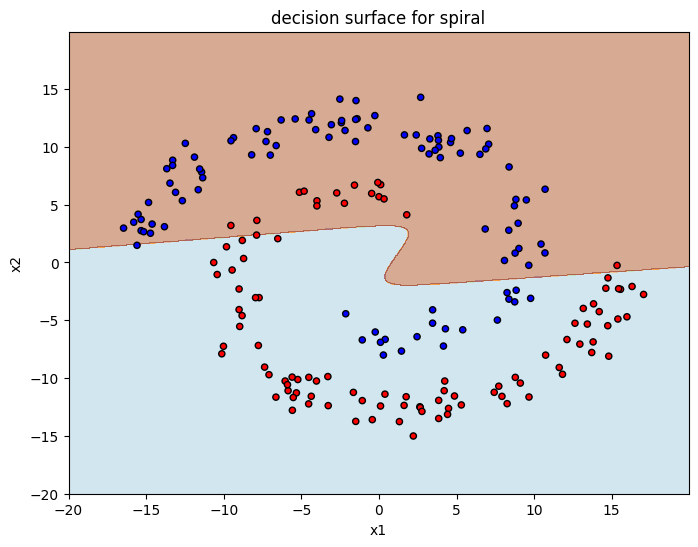

In [65]:
# FFNN Class Definition
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False)
        #use Sigmoid as activation function
        self.activation_fn = activation
    
    def forward(self, x):
        #apply activation function after doing linear combination between input layer and hidden layer.
        x = self.activation_fn(self.fc1(x))
        # since we are using Cross entropy loss as the loss function， we dont need activation function for output layer
        x = self.fc2(x)
        return x

# Training and Evaluation Helper Functions

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    """
    params:
        model: A model instance (FFNN in our case)
        train_loader: A DataLoader type for training data for each iteration
        val_loader: A DataLoader type for validation data, which is used for each iteration.
        criterion: The loss function used (e.g: Muti-class Cross Entropy loss function)
        optimizer: 
        epochs: the number of training and validation iteration.
    """
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train() # set model to train mode
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            #clear the gradient stored in the optimizer.
            y_batch = y_batch.squeeze().long()
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            #use gradient descent to train mode by using backward(), calculating the gradient, and step(), do the gradient descent process.
            loss.backward()
            optimizer.step()
            #calculate the average loss of this epoch and store it in train_loss list
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_epoch_loss = 0
        for x_val, y_val in val_loader:
            y_val = y_val.squeeze().long()
            val_output = model(x_val)
            val_loss_batch = criterion(val_output, y_val)
            val_epoch_loss += val_loss_batch.item()
        val_loss.append(val_epoch_loss / len(val_loader))
    return train_loss, val_loss

def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_batch = y_batch.squeeze().long()
            output = model(x_batch)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total
def load_data(name):
        x_train, y_train, _ = read_data(name, 'train')
        x_test, y_test, _ = read_data(name, 'test')
        x_val, y_val, _ = read_data(name, 'valid')
        
        x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
        x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
        x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
        
        # Loaders for batching
        train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_train, y_train), batch_size=16, shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_val, y_val), batch_size=16, shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_test, y_test), batch_size=16, shuffle=False)
        
        return train_loader, val_loader, test_loader
    

# Hyperparameters and configurations
print(" Pytorch Implementation with MCE: ")
nodes_options = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]
print(f"hyperparameters: \n epochs: {epochs} \n learning_rate: {learning_rate} \n batch size: 16")
for name in dataset_names:
    train_loader, val_loader, test_loader = load_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    for node in nodes_options:
        # two weights and 1 bias
        ffnn = FFNN(3, node, 2, nn.Tanh())
        criterion = nn.CrossEntropyLoss()
        # use Stochastic Gradient Descent as my optimizer
        optimizer = optim.SGD(ffnn.parameters(), lr = learning_rate)
        # get the list of train loss, validation loss for each epoch
        train_loss, val_loss = train_model(ffnn, train_loader, val_loader, criterion, optimizer, epochs)
        # get accuracy of model
        accuracy = evaluate_model(ffnn, test_loader)
        #find best accuracy and other variables
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ffnn
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"final text accuracy for {name}: {best_accuracy}")
    x_test, y_test, _ = read_data(name, 'test')
    y_test = y_test.squeeze()
    x_test = x_test = x_test[:, 1:]
    if name == "spiral":
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}", axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}")

## Pytorch Implementation with MSE

**Design choice:** Again we choose the same parameters, this way I can setup a controlled environment test the difference in result between two lost function.

 Pytorch Implementation with MSE: 
hyperparameters: 
 epochs: 100 
 learning_rate: 0.01 
 batch size: 16


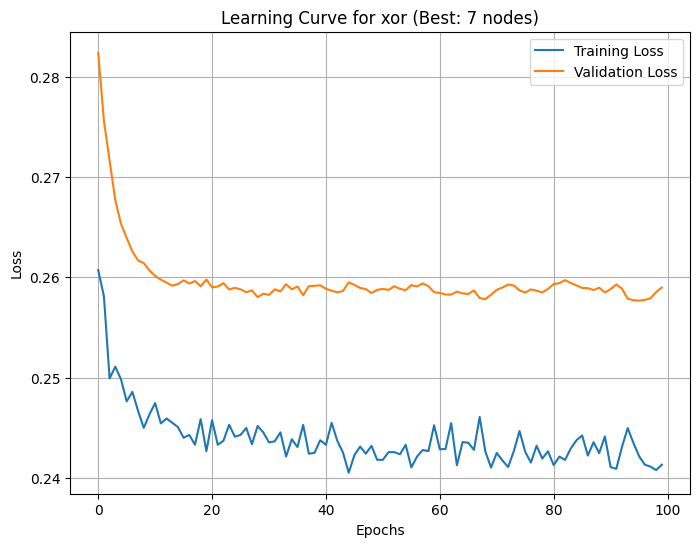

final text accuracy for xor: 0.575


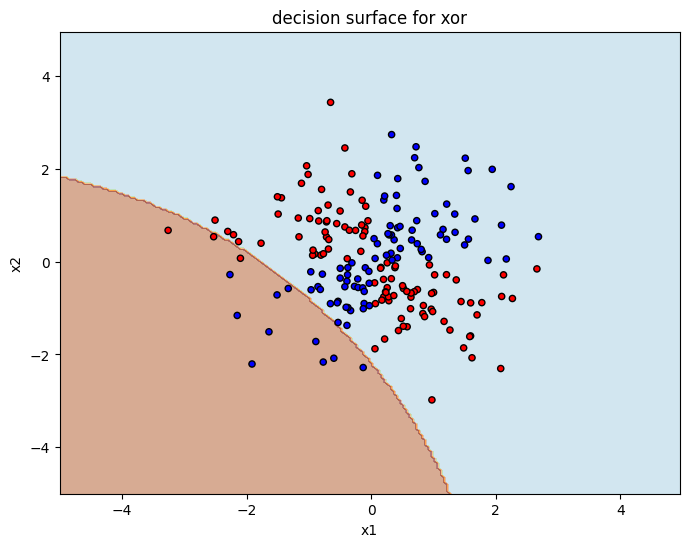

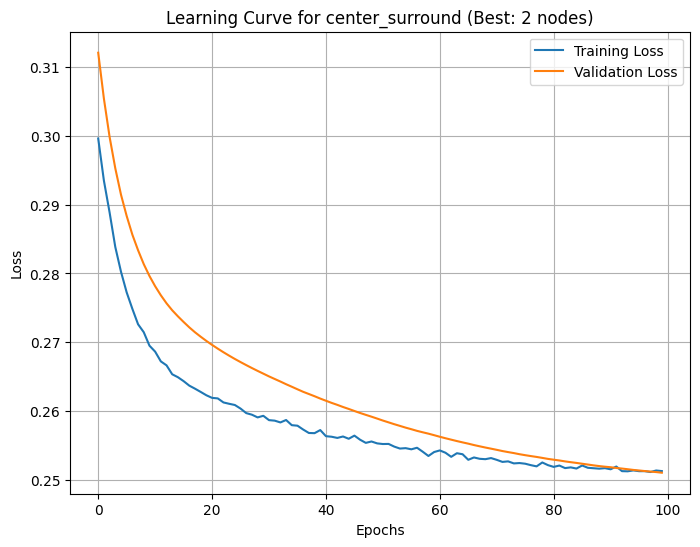

final text accuracy for center_surround: 0.61


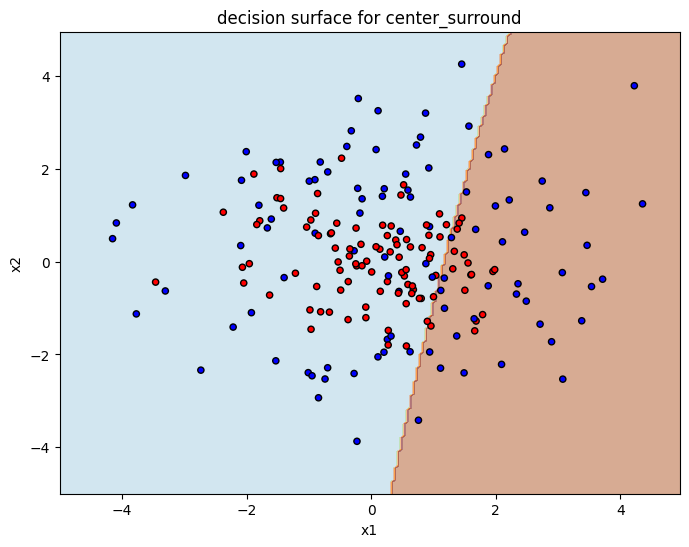

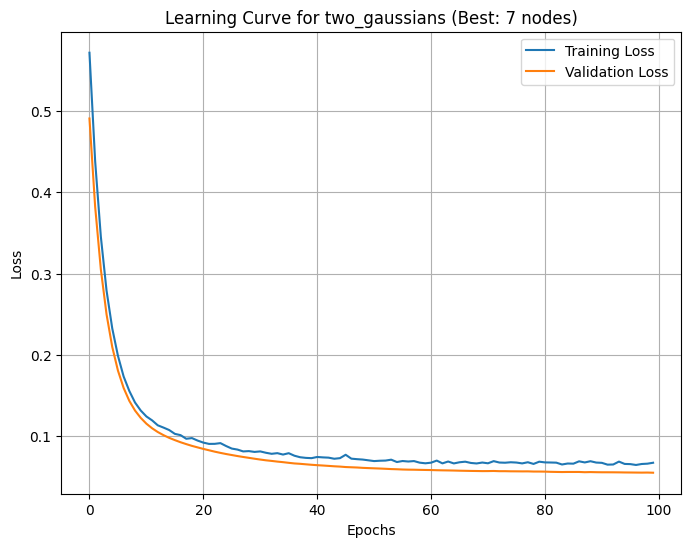

final text accuracy for two_gaussians: 0.93


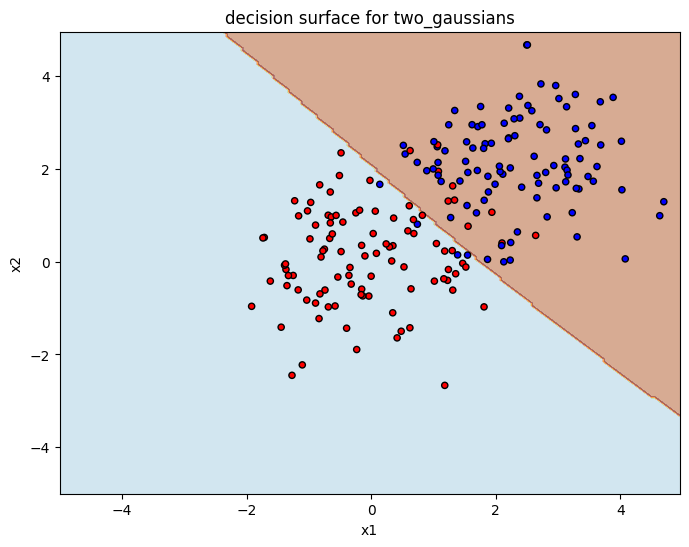

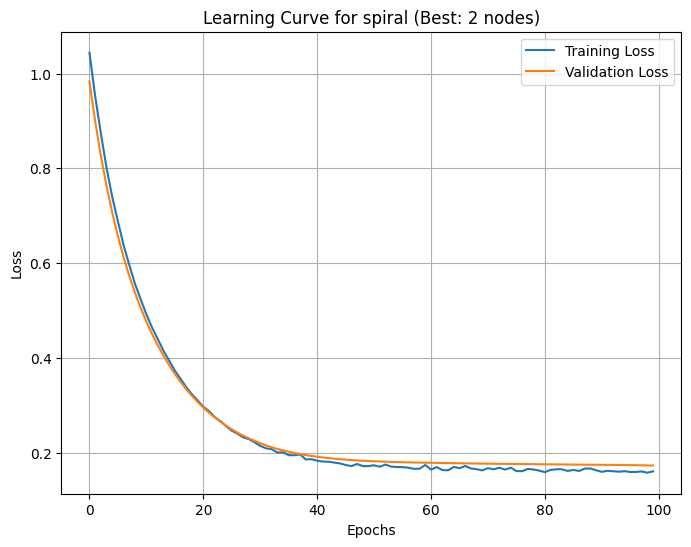

final text accuracy for spiral: 0.805


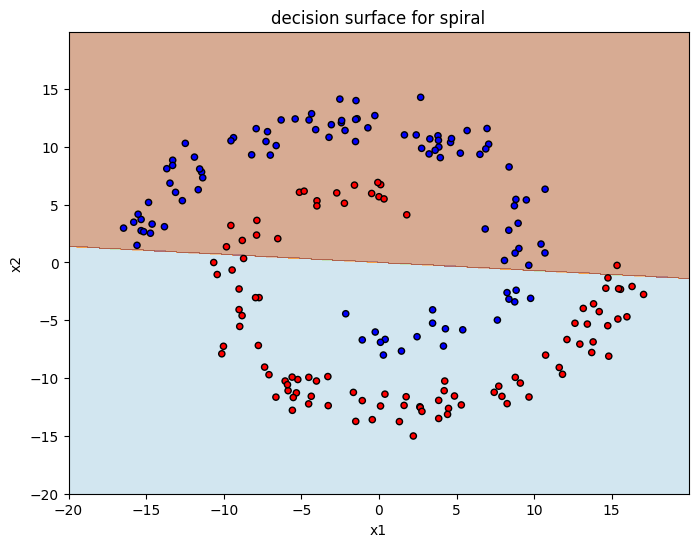

In [66]:
import torch.nn.functional as F
print(" Pytorch Implementation with MSE: ")
def train_model_MSE(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train()  # set model to train mode
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            # Convert y_batch to one-hot encoding for MSE
            y_batch = F.one_hot(y_batch.squeeze().long(), num_classes=2).float()
            
            optimizer.zero_grad()
            output = model(x_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_val = F.one_hot(y_val.squeeze().long(), num_classes=2).float()
                val_output = model(x_val)
                val_loss_batch = criterion(val_output, y_val)
                val_epoch_loss += val_loss_batch.item()
        val_loss.append(val_epoch_loss / len(val_loader))
    return train_loss, val_loss

def evaluate_model_MSE(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            output = model(x_batch)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y_batch.squeeze()).sum().item()
            total += y_batch.size(0)
    return correct / total

nodes_options = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]
print(f"hyperparameters: \n epochs: {epochs} \n learning_rate: {learning_rate} \n batch size: 16")
for name in dataset_names:
    train_loader, val_loader, test_loader = load_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    for node in nodes_options:
        # two weights and 1 bias, and use Sigmoid() to train
        ffnn = FFNN(3, node, 2, nn.Sigmoid())
        criterion = nn.MSELoss()
        # use Stochastic Gradient Descent as my optimizer
        optimizer = optim.SGD(ffnn.parameters(), lr = learning_rate)
        # get the list of train loss, validation loss for each epoch
        train_loss, val_loss = train_model_MSE(ffnn, train_loader, val_loader, criterion, optimizer, epochs)
        # get accuracy of model
        accuracy = evaluate_model_MSE(ffnn, test_loader)
        #find best accuracy and other variables
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ffnn
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"final text accuracy for {name}: {best_accuracy}")
    x_test, y_test, _ = read_data(name, 'test')
    y_test = y_test.squeeze()
    x_test = x_test = x_test[:, 1:]
    if name == "spiral":
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}", axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface(best_model,x_test, y_test, title = f"decision surface for {name}")

## manual gradient and update

**Design choice:** We decided to implement FFNN with MCE as cost function manually. Including things like explicit forward propagation and manual gradient calculation. We also implement the cross entropy loss to ensure smooth gradient update. 

Same as before, we use Epoch 100 with batch size 16 and learning rate of 0.1. We want to maintain consistency and make the comparison between different implementation easier.

Manual Implementation with Cross-Entropy Loss:

Training on xor dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.6250
  Training with 3 hidden nodes...
    Accuracy: 0.8200
  Training with 5 hidden nodes...
    Accuracy: 0.9050
  Training with 7 hidden nodes...
    Accuracy: 0.9200
  Training with 9 hidden nodes...
    Accuracy: 0.9250


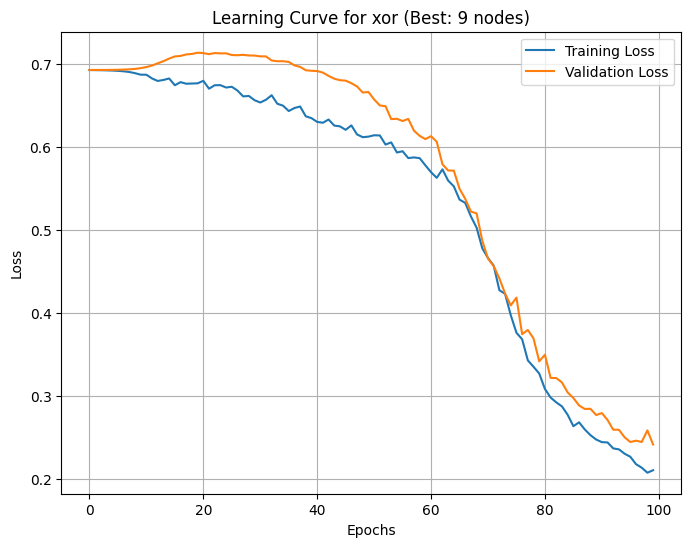

Final test accuracy for xor: 0.925


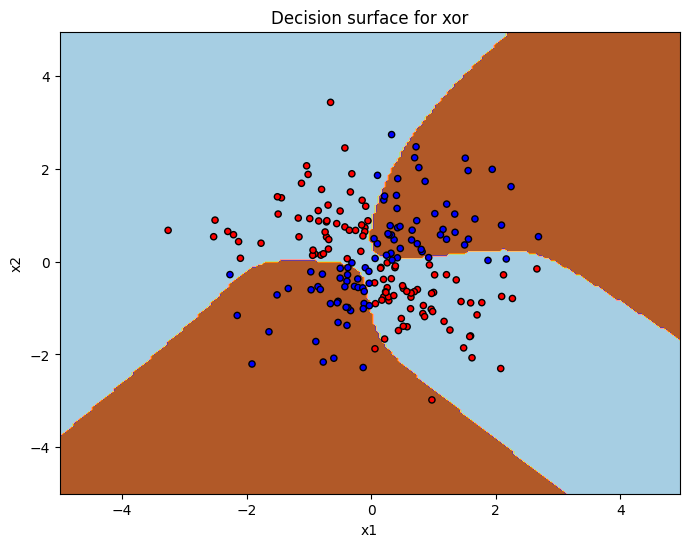


Training on center_surround dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.6200
  Training with 3 hidden nodes...
    Accuracy: 0.6500
  Training with 5 hidden nodes...
    Accuracy: 0.7450
  Training with 7 hidden nodes...
    Accuracy: 0.7550
  Training with 9 hidden nodes...
    Accuracy: 0.7500


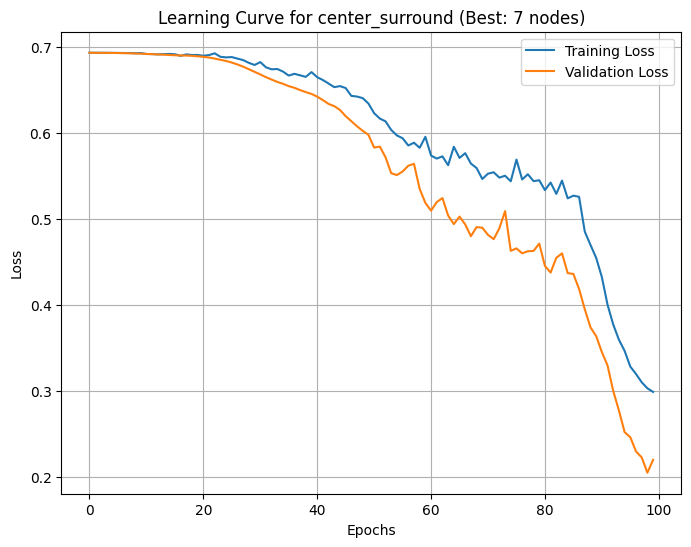

Final test accuracy for center_surround: 0.755


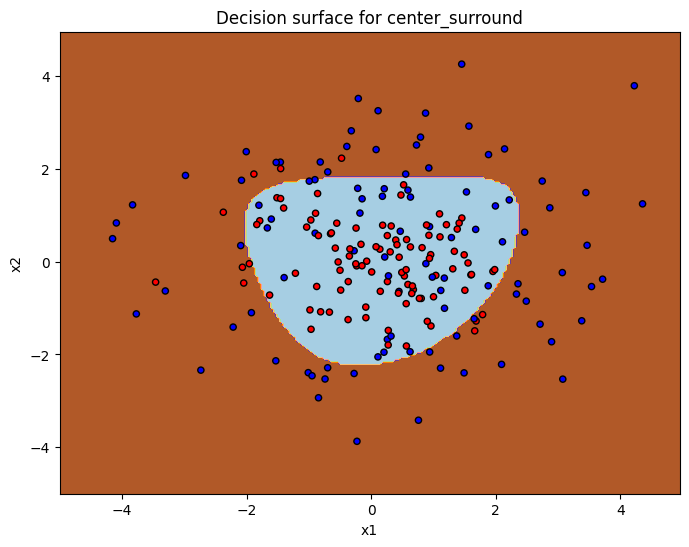


Training on two_gaussians dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.9150
  Training with 3 hidden nodes...
    Accuracy: 0.9100
  Training with 5 hidden nodes...
    Accuracy: 0.9100
  Training with 7 hidden nodes...
    Accuracy: 0.9150
  Training with 9 hidden nodes...
    Accuracy: 0.9100


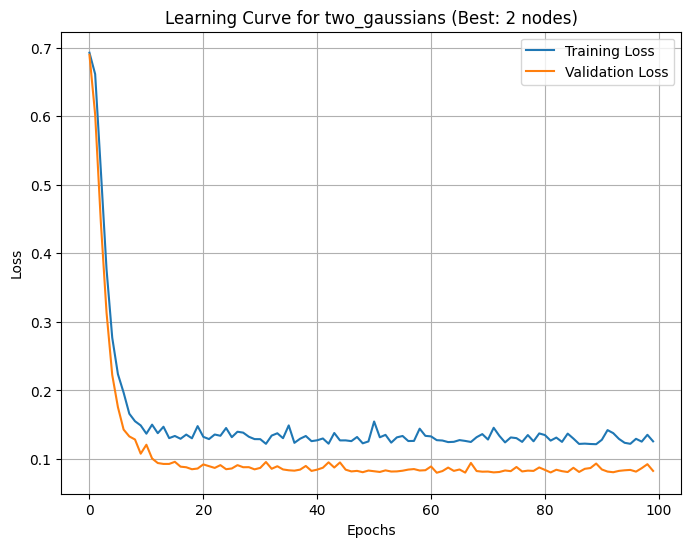

Final test accuracy for two_gaussians: 0.915


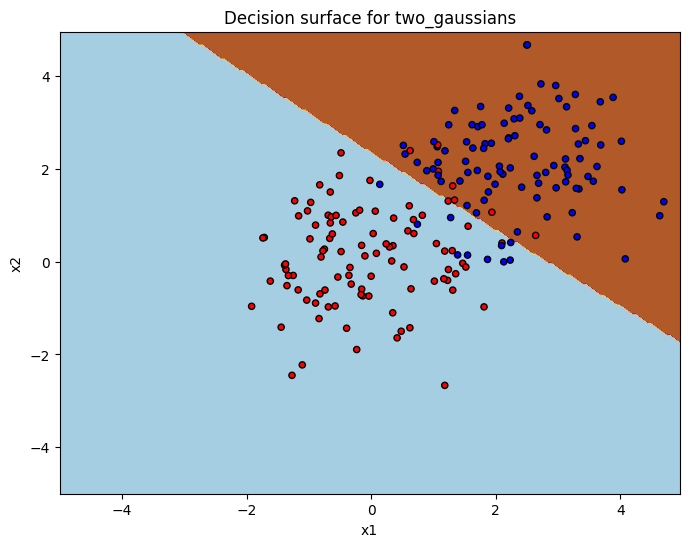


Training on spiral dataset:
  Training with 2 hidden nodes...
    Accuracy: 0.7700
  Training with 3 hidden nodes...
    Accuracy: 0.7500
  Training with 5 hidden nodes...
    Accuracy: 0.7600
  Training with 7 hidden nodes...
    Accuracy: 0.7650
  Training with 9 hidden nodes...
    Accuracy: 0.7600


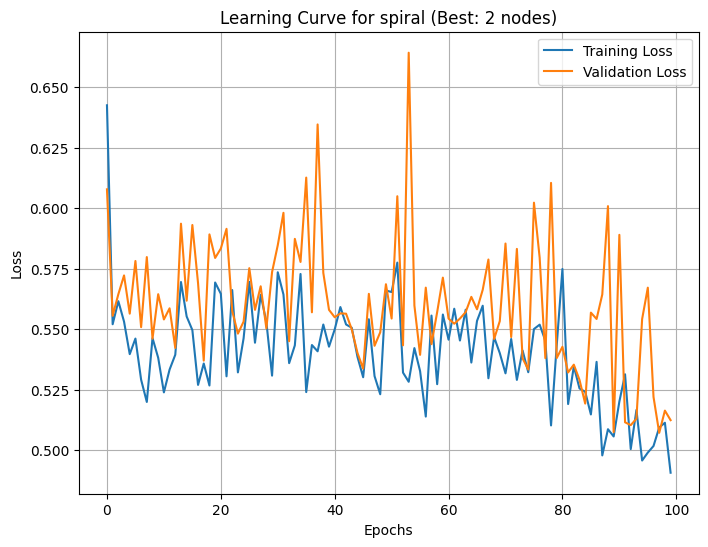

Final test accuracy for spiral: 0.77


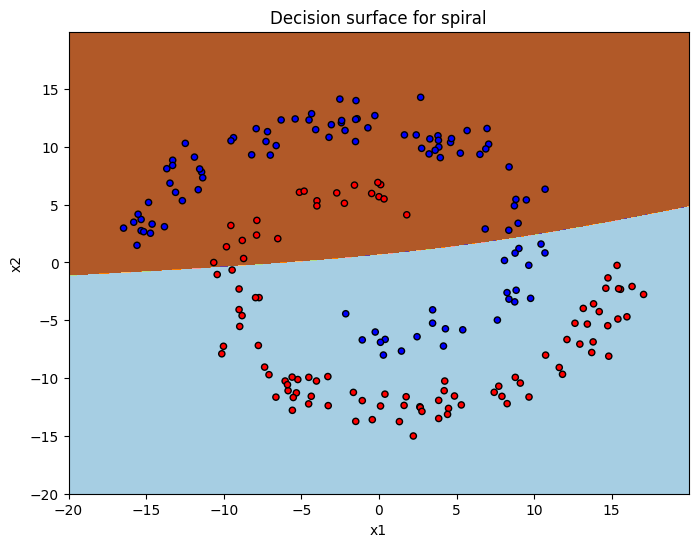

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class ManualFFNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        # Initialize weights with random values
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        
        # Store dimensions
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # Store intermediate values for backpropagation
        self.x = None
        self.z1 = None
        self.a1 = None
        self.z2 = None
        self.a2 = None

    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_derivative(self, x):
        return 1.0 - np.tanh(x)**2
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        # exp_x = np.exp(x)
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def forward(self, x):
        # Store input
        self.x = x
        
        # First layer
        self.z1 = np.dot(x, self.W1)
        self.a1 = self.tanh(self.z1)
        
        # Second layer
        self.z2 = np.dot(self.a1, self.W2)
        self.a2 = self.softmax(self.z2)
        
        return self.a2
    
    def backward(self, y):
        batch_size = self.x.shape[0]
        
        # Convert y to one-hot encoding if it's not already
        if len(y.shape) == 1:
            y_one_hot = np.zeros((batch_size, self.output_dim))
            y_one_hot[np.arange(batch_size), y.astype(int)] = 1
        else:
            y_one_hot = y
        
        # Gradient calculations
        dz2 = self.a2 - y_one_hot
        dW2 = np.dot(self.a1.T, dz2)
        da1 = np.dot(dz2, self.W2.T)
        dz1 = da1 * self.tanh_derivative(self.z1)
        dW1 = np.dot(self.x.T, dz1)
        
        return dW1, dW2
    
    def cross_entropy_loss(self, y_pred, y_true):
        batch_size = y_pred.shape[0]
        if len(y_true.shape) == 1:
            y_true = y_true.astype(int)
            y_true_one_hot = np.zeros((batch_size, self.output_dim))
            y_true_one_hot[np.arange(batch_size), y_true] = 1
        else:
            y_true_one_hot = y_true
            
        return -np.sum(y_true_one_hot * np.log(y_pred + 1e-8)) / batch_size


def plot_decision_surface_manual(model=None,
                                 axis_limits=(-5, 5, -5, 5),
                                 ax: matplotlib.axes.Axes = None):
    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Add bias column
    bias_column = np.ones((data.shape[0], 1))
    data_with_bias = np.hstack([bias_column, data])
    # print(f"data_with_bias shape: {data_with_bias.shape}")  # Debugging

    # Predict the class of each point
    predicted_labels = model.forward(data_with_bias)
    # print(f"Forward output shape: {predicted_labels.shape}")  # Debugging

    # Take argmax to get class indices
    predicted_labels = np.argmax(predicted_labels, axis=1)
    # print(f"Predicted labels shape after argmax: {predicted_labels.shape}")  # Debugging

    # Reshape to match the grid shape
    assert predicted_labels.size == xx.size, (
        f"Mismatch: predicted_labels size ({predicted_labels.size}) does not match grid size ({xx.size})."
    )
    predicted_labels = predicted_labels.reshape(xx.shape)

    # Plot the result
    if ax is None:
        ax = plt
    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')
    if ax is None:
        plt.show()

def plot_best_decision_surface_manual(model, x_test, y_test, title="Decision Surface", axis_limits = (-5,5,-5,5)):
    """
    Plot the decision surface of the best model using test data.

    Parameters:
    - model: Trained model to generate predictions.
    - x_test: Test dataset features (2D array).
    - y_test: Test dataset labels.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plot_decision_surface_manual(model=model, axis_limits = axis_limits)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

def train_manual_model(model, x_train, y_train, x_val, y_val, learning_rate, epochs, batch_size):
    train_loss = []
    val_loss = []
    n_samples = x_train.shape[0]
    n_batches = (n_samples + batch_size - 1) // batch_size
    
    for epoch in range(epochs):
        epoch_loss = 0
        indices = np.random.permutation(n_samples)
        x_train = x_train[indices]
        y_train = y_train[indices]
        
        for i in range(n_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, n_samples)
            
            x_batch = x_train[start_idx:end_idx]
            y_batch = y_train[start_idx:end_idx]
            
            y_pred = model.forward(x_batch)
            batch_loss = model.cross_entropy_loss(y_pred, y_batch)
            epoch_loss += batch_loss
            
            dW1, dW2 = model.backward(y_batch)
            
            model.W1 -= learning_rate * dW1
            model.W2 -= learning_rate * dW2
        
        val_pred = model.forward(x_val)
        val_epoch_loss = model.cross_entropy_loss(val_pred, y_val)
        
        train_loss.append(epoch_loss / n_batches)
        val_loss.append(val_epoch_loss)
    
    return train_loss, val_loss

def evaluate_manual_model(model, x_test, y_test):
    predictions = model.forward(x_test)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = y_test.astype(int)
    return np.mean(predicted_classes == true_classes)

def load_manual_data(name):
    x_train, y_train, _ = read_data(name, 'train')
    x_test, y_test, _ = read_data(name, 'test')
    x_val, y_val, _ = read_data(name, 'valid')
    
    x_train = np.array(x_train, dtype=np.float32)
    y_train = np.array(y_train, dtype=np.float32).reshape(-1)
    x_val = np.array(x_val, dtype=np.float32)
    y_val = np.array(y_val, dtype=np.float32).reshape(-1)
    x_test = np.array(x_test, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32).reshape(-1)
    
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

# Main training loop
print("Manual Implementation with Cross-Entropy Loss:")
nodes_options = [2, 3, 5, 7, 9]
epochs = 100
learning_rate = 0.01
batch_size = 16
dataset_names = ["xor", "center_surround", "two_gaussians", "spiral"]

for name in dataset_names:
    print(f"\nTraining on {name} dataset:")
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = load_manual_data(name)
    best_accuracy = 0
    best_model = None
    best_k = 0
    best_train_loss, best_val_loss = None, None
    
    for node in nodes_options:
        print(f"  Training with {node} hidden nodes...")
        model = ManualFFNN(input_dim=3, hidden_dim=node, output_dim=2)
        train_loss, val_loss = train_manual_model(
            model, x_train, y_train, 
            x_val, y_val, 
            learning_rate, epochs, batch_size
        )
        accuracy = evaluate_manual_model(model, x_test, y_test)
        print(f"    Accuracy: {accuracy:.4f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model
            best_k = node
            best_train_loss, best_val_loss = train_loss, val_loss
    
    plot_learning_curves(best_train_loss, best_val_loss, 
                        f"Learning Curve for {name} (Best: {best_k} nodes)")
    print(f"Final test accuracy for {name}: {best_accuracy}")
    
    x_test_plot = x_test[:, 1:]  # Remove bias term for plotting
    if name == "spiral":
        plot_best_decision_surface_manual(best_model, x_test_plot, y_test, 
                                 title=f"Decision surface for {name}", 
                                 axis_limits=(-20, 20, -20, 20))
    else:
        plot_best_decision_surface_manual(best_model, x_test_plot, y_test, 
                                 title=f"Decision surface for {name}")

## Adding Regularizers

**Design choice**: Using what we had in step 2 with the same parameters, we added two Regularizers, Frobenius Norm Regularizer and Orthogonality Regularizer. We use `lambda_norm` and `lambda_orth` to control the impact of the regularizer on the training of the model. 

With the regularizer in place we can see a significant increase in the testing accuracy of xor. Overall several run we see an increase from around 55% accuracy without regularizer to around 80% with regularizer. 

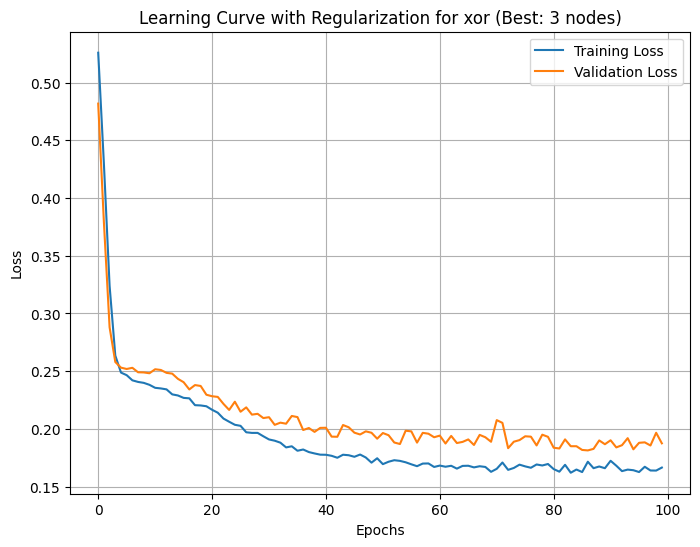

Final test accuracy for xor with regularization: 0.82


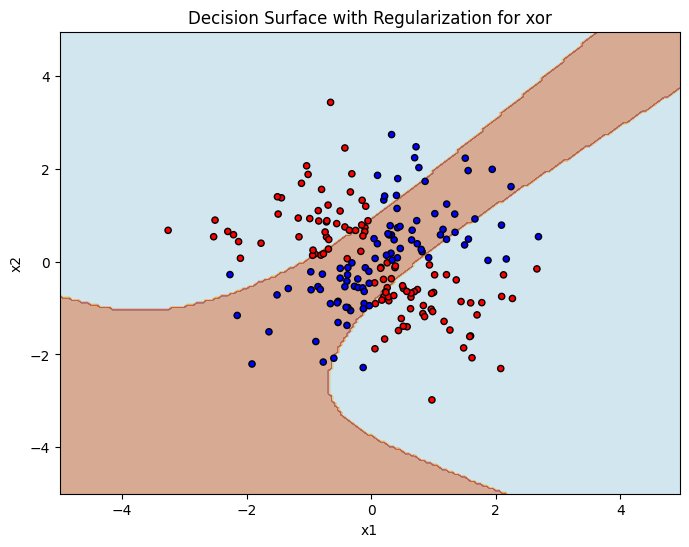

In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## function for plot learning curves

def plot_learning_curves(train_loss, val_loss, title="Learning Curves"):
    """
    Plot the learning curves for training and validation loss.

    Parameters:
    - train_loss: List of training loss values over epochs.
    - val_loss: List of validation loss values over epochs.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(train_loss, label="Training Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: plt.Axes = None):

    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], 0.05),
                         np.arange(axis_limits[2], axis_limits[3], 0.05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Add a bias term of 1 to each point in the grid, resulting in shape [N, 3]
    bias_column = np.ones((data.shape[0], 1))  # Create a column of ones for the bias term
    data_with_bias = np.hstack([bias_column, data])  # Combine bias, x1, and x2 columns
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data_with_bias, dtype=torch.float32))
            predicted_labels = torch.argmax(pl, dim=1).numpy()  # Get class predictions
    else:
        predicted_labels = model(data_with_bias)
    predicted_labels = predicted_labels.reshape(xx.shape)
    if ax is None:
        ax = plt
    contour = ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired, alpha=0.5)
    ax.axis('equal')
    ax.axis('tight')
    if ax is None:
        plt.show()
    return contour

def plot_best_decision_surface(model, x_test, y_test, title="Decision Surface", axis_limits = (-5,5,-5,5)):
    """
    Plot the decision surface of the best model using test data.

    Parameters:
    - model: Trained model to generate predictions.
    - x_test: Test dataset features (2D array).
    - y_test: Test dataset labels.
    - title: Title of the plot.
    """
    plt.figure(figsize=(8, 6))
    plot_decision_surface(model=model, axis_limits = axis_limits)
    plt.scatter(x_test[:, 0], x_test[:, 1], c=y_test, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolor='k', s=20)
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()



# FFNN Class Definition
class FFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, activation):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=False)
        self.fc2 = nn.Linear(hidden_dim, output_dim, bias=False)
        #use Sigmoid as activation function
        self.activation_fn = activation
    
    def forward(self, x):
        #apply activation function after doing linear combination between input layer and hidden layer.
        x = self.activation_fn(self.fc1(x))
        # since we are using Cross entropy loss as the loss function， we dont need activation function for output layer
        x = self.fc2(x)
        return x
    
def load_data(name):
        x_train, y_train, _ = read_data(name, 'train')
        x_test, y_test, _ = read_data(name, 'test')
        x_val, y_val, _ = read_data(name, 'valid')
        
        x_train, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
        x_val, y_val = torch.tensor(x_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
        x_test, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
        
        # Loaders for batching
        train_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_train, y_train), batch_size=16, shuffle=True)
        val_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_val, y_val), batch_size=16, shuffle=False)
        test_loader = torch.utils.data.DataLoader(dataset=torch.utils.data.TensorDataset(x_test, y_test), batch_size=16, shuffle=False)
        
        return train_loader, val_loader, test_loader

def train_model_with_regularization(
    model, train_loader, val_loader, criterion, optimizer, epochs, lambda_norm=0.01, lambda_orth=0.01
):
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for x_batch, y_batch in train_loader:
            y_batch = y_batch.squeeze().long()
            optimizer.zero_grad()
            output = model(x_batch)
            y_one_hot = F.one_hot(y_batch, num_classes=output.size(1)).float()
            loss = criterion(output, y_one_hot)
            
            # Frobenius norm regularization
            reg_norm = lambda_norm * torch.norm(model.fc1.weight, p='fro')
            
            # Orthogonality regularization
            weight = model.fc1.weight
            reg_orth = lambda_orth * torch.sum((weight @ weight.T - torch.eye(weight.size(0)).to(weight.device)) ** 2)
            
            # Combine total loss
            total_loss = loss + reg_norm + reg_orth
            total_loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        train_loss.append(epoch_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                y_val = y_val.squeeze().long()
                val_output = model(x_val)

                y_val_one_hot = F.one_hot(y_val, num_classes=val_output.size(1)).float()
                val_loss_batch = criterion(val_output, y_val_one_hot)
                
                # Use regularization terms without recalculating weight
                val_epoch_loss += val_loss_batch.item()
        
        # Append validation loss per epoch
        val_loss.append(val_epoch_loss / len(val_loader))

    return train_loss, val_loss


def evaluate_model(model, data_loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            y_batch = y_batch.squeeze().long()
            output = model(x_batch)
            predictions = torch.argmax(output, dim=1)
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)
    return correct / total

lambda_norm = 0.01
lambda_orth = 0.01
learning_rate = 0.1
epochs = 100
dataset_names = ["xor"]
nodes_options = [3]

for name in dataset_names:
    train_loader, val_loader, test_loader = load_data(name)
    best_accuracy = 0
    best_model = None
    best_train_loss, best_val_loss = None, None
    for node in nodes_options:
        # two weights and 1 bias
        ffnn = FFNN(3, node, 2, nn.Tanh())
        # criterion = nn.CrossEntropyLoss()
        criterion = nn.MSELoss()
        # use Stochastic Gradient Descent as my optimizer
        optimizer = optim.SGD(ffnn.parameters(), lr=learning_rate)
        # get the list of train loss, validation loss for each epoch
        train_loss, val_loss = train_model_with_regularization(ffnn, train_loader, val_loader, criterion, optimizer, epochs, lambda_norm, lambda_orth)
        # get accuracy of model
        accuracy = evaluate_model(ffnn, test_loader)
        # find best accuracy and other variables
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = ffnn
            best_train_loss, best_val_loss = train_loss, val_loss

plot_learning_curves(best_train_loss, best_val_loss, f"Learning Curve with Regularization for {name} (Best: {node} nodes)")
print(f"Final test accuracy for {name} with regularization: {best_accuracy}")

# Plot the decision surface regularization
x_test, y_test, _ = read_data(name, 'test')
y_test = y_test.squeeze()
x_test = x_test[:, 1:]
plot_best_decision_surface(best_model, x_test, y_test, title=f"Decision Surface with Regularization for {name}")